In [1]:
import os
import sys
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

data_dir = '../yelp/dataset/'

Using TensorFlow backend.


In [2]:
os.listdir(data_dir)

['business.json',
 'test.csv',
 'photos.json',
 'Dataset_Challenge_Dataset_Agreement.pdf',
 'user.json',
 'Yelp_Dataset_Challenge_Round_11.pdf',
 'checkin.json',
 'tip.json',
 'train.csv',
 'review.json']

In [4]:
#df_biz = pd.read_json(data_dir+'business.json', lines=True)

In [28]:
# df_chkin = pd.read_json(data_dir+'checkin.json', lines=True)

In [3]:
# df_review = pd.read_json(data_dir+'review.json', lines=True)

## User Clustering
1. Cluster geographically to coerce users to have local relevance
2. Cluster on business type data (requires preprocessing).

In [6]:
# df_user = pd.read_json(data_dir+'user.json', lines=True)
# del df_user

## Train Set

Given user actions here, can we match users in an external set with restaraunts they have rated highly. We will begin by reduce the amount to users who have conistent activity and to businesses that are open. Then get the most popular categories and build those into features. We will suggest restaraunts based on features so we will attempt to predict a business id using the popular category types others used.

In [4]:
pd.set_option('display.max_columns', 500)

In [13]:
# df_test = pd.read_csv(data_dir+'train.csv',encoding = "ISO-8859-1")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,2,4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
import sys

# subset = df_test.iloc[:,[1,6,9]]
subset = pd.read_csv('./simple_train.csv')

In [3]:
subset[['user_id','business_id','stars']].to_csv('simple_train.csv')

In [5]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
# Use the famous SVD algorithm.
algo = SVD()

from surprise import Dataset
from surprise import Reader

#subset = subset[subset['stars'] != '241 W Charleston Blvd, Ste 101']
#subset['stars'] = subset['stars'].astype(int)

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(subset[['user_id','business_id','stars']], reader)

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2423  1.2433  1.2423  1.2411  1.2431  1.2424  0.0008  
MAE (testset)     1.0018  1.0033  1.0019  1.0010  1.0031  1.0022  0.0009  
Fit time          138.09  139.17  137.37  135.58  131.62  136.36  2.65    
Test time         4.76    3.92    3.95    3.66    4.30    4.12    0.38    


{'fit_time': (138.09405279159546,
  139.16821718215942,
  137.36526012420654,
  135.57648587226868,
  131.61524200439453),
 'test_mae': array([ 1.00182545,  1.00330511,  1.00187895,  1.00101688,  1.00312549]),
 'test_rmse': array([ 1.2423123 ,  1.24327846,  1.24234961,  1.24112434,  1.24313772]),
 'test_time': (4.759120941162109,
  3.922222852706909,
  3.947373867034912,
  3.656209707260132,
  4.299277067184448)}

In [27]:
subset['stars'].unique()

array([1, 2, 3, 4, 5, '1', '3', '4', '2', '5',
       '241 W Charleston Blvd, Ste 101'], dtype=object)

In [7]:
# get users who have more than 2 reviews in the data set
val_count = df_test.user_id.value_counts()
value_users = val_count[val_count > 2].index.values

In [8]:
# limit the dataframe to users who have activity and open restaraunts
df_s = df_test[df_test['user_id'].apply(str).isin(value_users) & df_test['is open'] == 1]
len(df_s)

937219

Not proving too accuracte in current state.

In [9]:
# cluster latitude, longitude
long_lati = df_s.iloc[:,[-4,-5]]
kmeans = KMeans(n_clusters=3, random_state=0).fit(long_lati)
id_label=kmeans.labels_

In [10]:
id_label

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

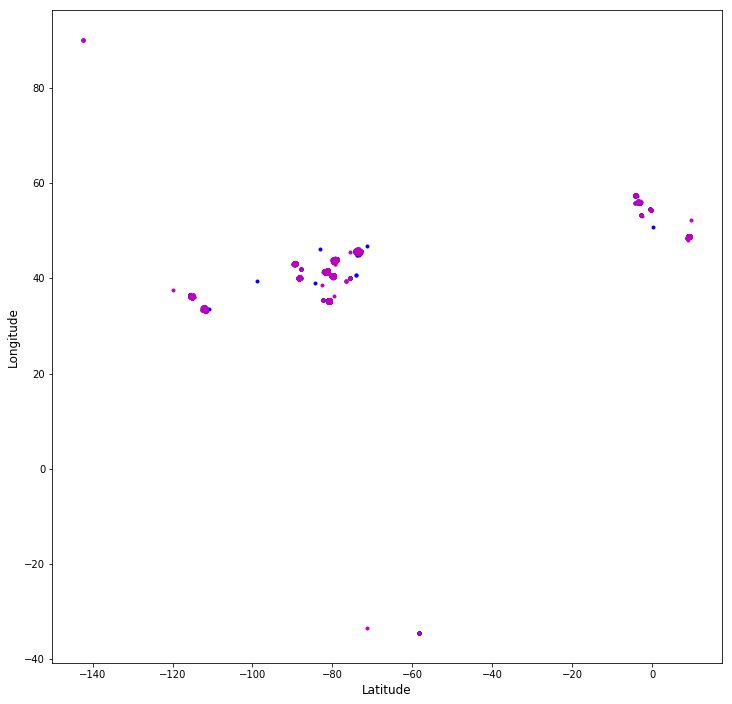

In [11]:
ptsymb = np.array(['b.','r.','m.']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(3):
    cluster=np.where(id_label==i)[0]
    plt.plot(long_lati.longitude[cluster].values,long_lati.latitude[cluster].values,ptsymb[i])
plt.show()

In [12]:
storage = Counter()

def initialize_dict(x):
    x = x.replace('&','').split(', ')
    for i in x:
        storage[i] += 1
        
df_s.category.apply(initialize_dict)
common_busi_types = [i[0] for i in storage.most_common(500)]

In [21]:
# common_busi_types

In [17]:
df_s.head(1)

Unnamed: 0             business_id cool        date funny  \
1    4407877  ALkOqlWODyxPg5VSp0HLrg    0  2015-06-01     0   

                review_id stars  \
1  duSPjhh5oW-PR-5hqZjEew     2   

                                                text useful  \
1  Was craving asian food so I ended up here and ...      0   

                  user_id               category      name neighborhood  \
1  zZSXs90-sXaYa6Axing0Iw  japanese, restaurants  Zakkushi          NaN   

              address     city state      zip  latitude  longitude  \
1  193 Carlton Street  Toronto    ON  M5A 2K9   43.6635   -79.3707   

   average_star  review count  is open  
1           4.0         216.0      1.0

In [15]:
# df_s.iloc[:,[-20,-18,-16,-3,-2]]

In [29]:
# string = 'be warned about the new reward program'
# del df_chkin
# df_chkin[df_chkin['text'].str.contains(string,case=False)]

KeyError: 'text'

In [25]:
from surprise import SVD
from surprise.model_selection import cross_validate

In [23]:
svd = SVD()

In [1]:
# cross_validate(svd, df_s.iloc[:,[1,6,9]], measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [7]:
# model = Sequential()
# model.add(Dense(1, input_shape=(2,), activation='sigmoid'))
# model.compile(Adam(lr=0.05), 'binary_crossentropy', metrics=['accuracy'])